--- 1. Data Loading and Initial Structuring ---


/tmp/ipython-input-2171917146.py:21: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Initial shape: (102599, 26)
Columns standardized.

--- 2. Data Cleaning and Type Conversion ---
Removed 541 duplicate rows.
Final shape after cleaning and outlier removal: (101270, 22)
Cleaned Price range: $50.00 to $1194.00

--- 3. Exploratory Data Analysis (EDA) ---

Analysis A: Average Total Cost by Room Type (USD):
         room_type  total_cost
0       Hotel room  798.556522
1      Shared room  757.380539
2     Private room  746.858237
3  Entire home/apt  746.653964


/tmp/ipython-input-2171917146.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='room_type', y='total_cost', data=price_by_room, palette='plasma')


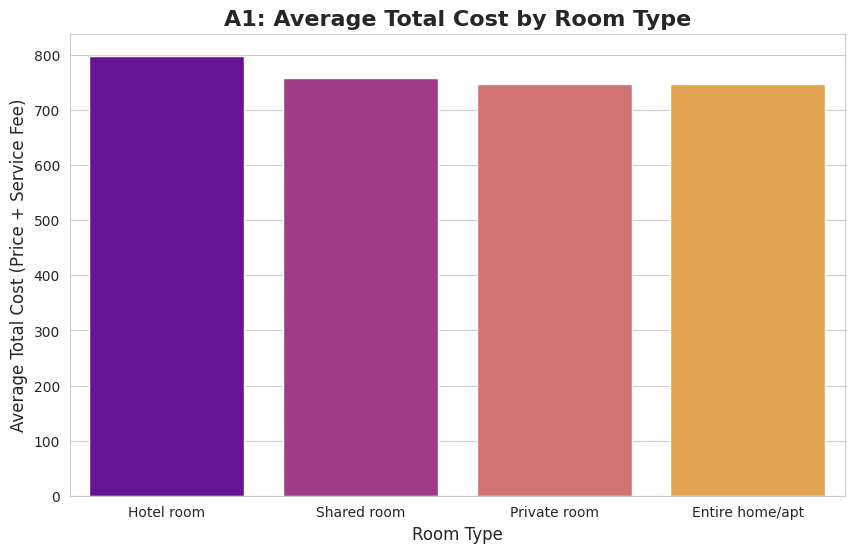


Analysis B: Average Total Cost by City Group (USD):
      city_group  total_cost
0         Queens  752.941917
1          Bronx  749.121723
2       Brooklyn  747.928994
3  Staten Island  747.179894
4      Manhattan  744.271342
5        brookln  696.000000
6       manhatan  585.000000


/tmp/ipython-input-2171917146.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='city_group', y='total_cost', data=price_by_city, palette='viridis')


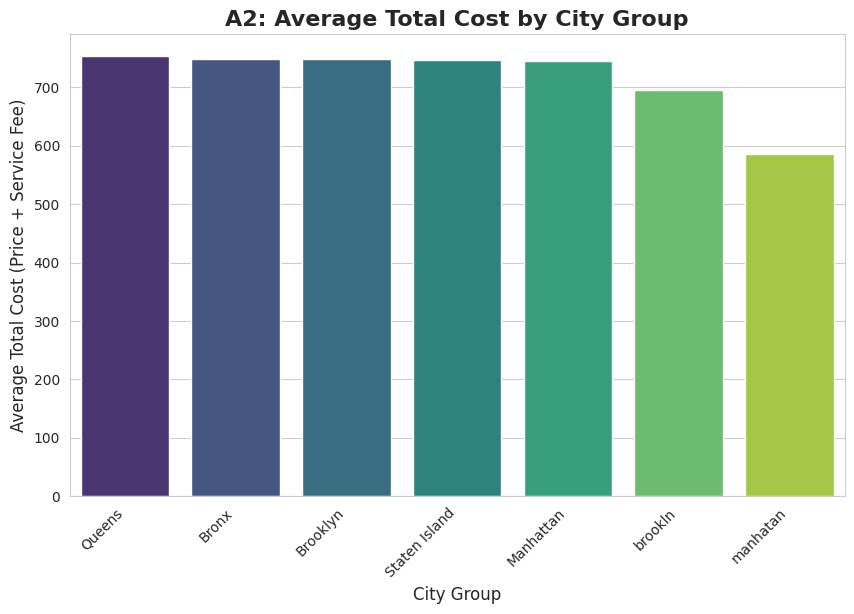

/tmp/ipython-input-2171917146.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_by_reviews = df.groupby('review_bin')['total_cost'].median().reset_index()
/tmp/ipython-input-2171917146.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='review_bin', y='total_cost', data=df, order=price_by_reviews['review_bin'], palette='Pastel1', showfliers=False)



Analysis C: Median Total Cost by Number of Reviews:
      review_bin  total_cost
0      0 Reviews       748.0
1   1-10 Reviews       744.0
2  11-50 Reviews       742.0
3    50+ Reviews       754.0


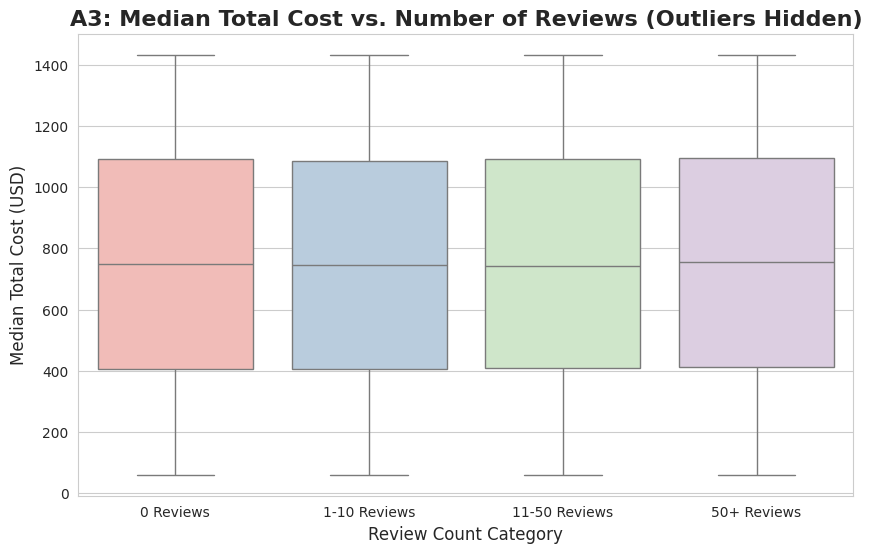


Analysis D: Correlation with Total Cost (Top Factors):
total_cost                        1.000000
price                             0.999939
service_fee                       0.998478
reviews_per_month                 0.005401
number_of_reviews                 0.005165
calculated_host_listings_count    0.000343
minimum_nights                   -0.002081
availability_365                 -0.003111
Name: total_cost, dtype: float64


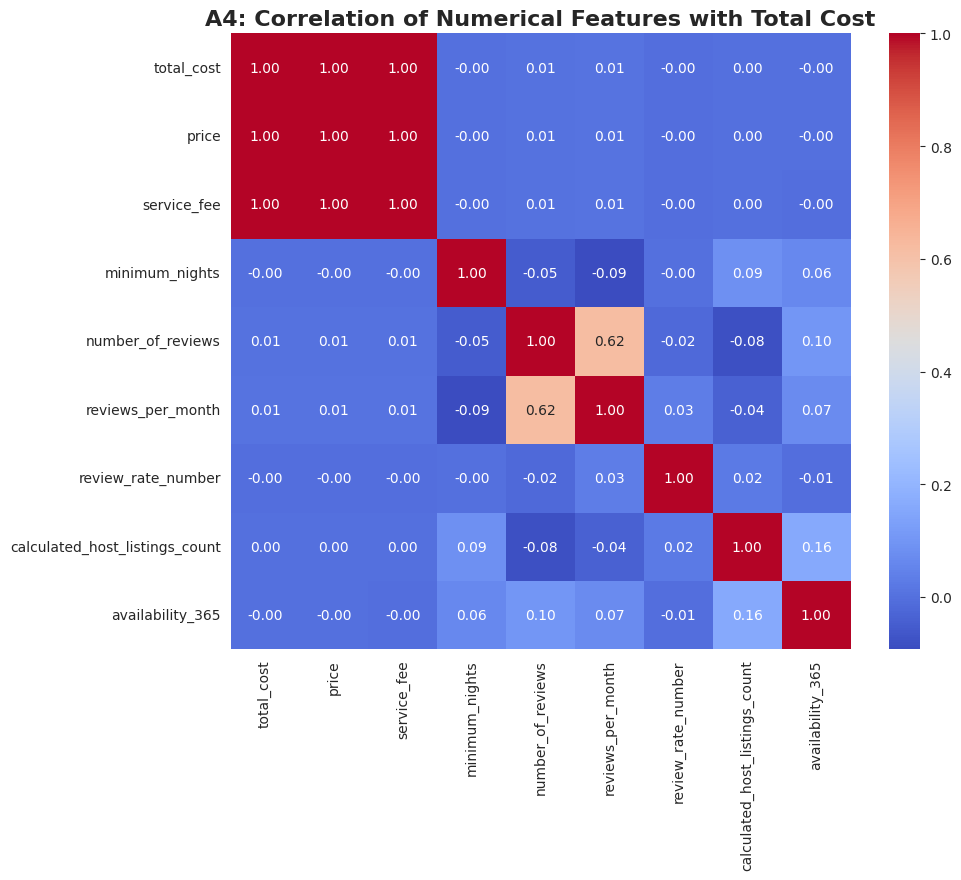


                PROJECT KEY FINDINGS               

1. PROPERTY TYPE (ROOM TYPE) is the Primary Price Driver:
   - **Highest Average Cost:** Hotel room (Avg. $798.56)
   - **Lowest Average Cost:** Entire home/apt (Avg. $746.65)
   - *Insight:* Entire Home/Apartment listings command the highest premium, while Shared Rooms are the most economical.

2. LOCATION (CITY GROUP) has a Significant Impact:
   - **Most Expensive Area:** Queens (Avg. $752.94)
   - **Least Expensive Area:** manhatan (Avg. $585.00)
   - *Insight:* Geographic demand and cost of living directly translate to listing prices.

3. HOST/LISTING BEHAVIOR and Review Metrics:
   - **Strongest Numerical Factor:** 'Reviews Per Month' (Correlation: 0.01)
   - *Insight:* High correlation suggests that hosts who are highly reviewed or have higher rating tend to charge more.

Conclusion: Price is primarily driven by what the guest buys (Room Type) and where they buy it (City Group).


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Set plotting style for professional look
sns.set_style("whitegrid")

# --- 1. CONFIGURATION AND DATA LOADING ---
# The path to the uploaded CSV file.
FILE_PATH = "/content/1730285881-Airbnb_Open_Data.csv"

def load_and_preprocess_data(file_path):
    """
    Loads the dataset and performs initial structural cleaning (column names).
    """
    print("--- 1. Data Loading and Initial Structuring ---")
    try:
        # Load the raw dataset
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

    # Step 1.1: Standardize Column Names
    # Convert column names to lowercase and replace spaces with underscores.
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    # Rename key columns for better clarity
    df.rename(columns={'host_id': 'host_id', 'host_name': 'host_name',
                       'neighbourhood_group': 'city_group',
                       'neighbourhood': 'neighborhood'}, inplace=True)

    print(f"Initial shape: {df.shape}")
    print("Columns standardized.")
    return df

def perform_data_cleaning(df):
    """
    Handles duplicate records, missing values, and data type conversions (especially currency).
    """
    print("\n--- 2. Data Cleaning and Type Conversion ---")

    # Step 2.1: Handle Duplicate Rows
    initial_rows = len(df)
    df.drop_duplicates(inplace=True)
    print(f"Removed {initial_rows - len(df)} duplicate rows.")

    # Step 2.2: Drop Irrelevant/Sparse Columns
    # 'license', 'house_rules', 'country', 'country_code' are dropped due to sparsity or irrelevance.
    df.drop(columns=['license', 'house_rules', 'country', 'country_code'],
            inplace=True, errors='ignore')

    # Step 2.3: Cleaning and Converting Price/Service Fee Columns
    for col in ['price', 'service_fee']:
        # Remove currency symbols and commas
        if col in df.columns and df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace(r'[^\d.]', '', regex=True)
        # Convert to numeric, coercing errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Step 2.4: Handling Missing Values (Imputation and Dropping)

    # Impute missing reviews: NaN implies 0 reviews per month.
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

    # Impute missing host name with 'Unknown'.
    df['host_name'] = df['host_name'].fillna('Unknown')

    # Convert 'last_review' to datetime object
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

    # Drop rows where essential categorical data is missing
    df.dropna(subset=['name', 'city_group', 'neighborhood', 'room_type'], inplace=True)

    # Fill remaining numeric NaNs (e.g., from conversion errors) with the median
    df['price'] = df['price'].fillna(df['price'].median())
    df['service_fee'] = df['service_fee'].fillna(df['service_fee'].median())

    # Ensure numerical features are integers where applicable
    for col in ['minimum_nights', 'number_of_reviews']:
        # Using errors='coerce' then fillna(0) for safe integer conversion if needed
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype('int')

    # Step 2.5: Outlier Handling for Price
    # Remove listings with zero price and extreme outliers (top 0.5% for robust analysis)
    price_upper_bound = df['price'].quantile(0.995)
    df = df[df['price'] > 0]
    df = df[df['price'] <= price_upper_bound]

    print(f"Final shape after cleaning and outlier removal: {df.shape}")
    print(f"Cleaned Price range: ${df['price'].min():.2f} to ${df['price'].max():.2f}")

    return df

def exploratory_data_analysis(df):
    """
    Performs key EDA to derive initial insights into pricing and its determining factors.
    """
    print("\n--- 3. Exploratory Data Analysis (EDA) ---")

    # Calculate Total Cost for comprehensive analysis
    df['total_cost'] = df['price'] + df['service_fee']

    # --- Analysis A: Impact of Property Type (Room Type) on Price ---
    price_by_room = df.groupby('room_type')['total_cost'].mean().sort_values(ascending=False).reset_index()
    print("\nAnalysis A: Average Total Cost by Room Type (USD):")
    print(price_by_room)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='room_type', y='total_cost', data=price_by_room, palette='plasma')
    plt.title('A1: Average Total Cost by Room Type', fontsize=16, fontweight='bold')
    plt.xlabel('Room Type', fontsize=12)
    plt.ylabel('Average Total Cost (Price + Service Fee)', fontsize=12)
    plt.show() #

    # --- Analysis B: Impact of Location (City Group) on Price ---
    price_by_city = df.groupby('city_group')['total_cost'].mean().sort_values(ascending=False).reset_index()
    print("\nAnalysis B: Average Total Cost by City Group (USD):")
    print(price_by_city)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='city_group', y='total_cost', data=price_by_city, palette='viridis')
    plt.title('A2: Average Total Cost by City Group', fontsize=16, fontweight='bold')
    plt.xlabel('City Group', fontsize=12)
    plt.ylabel('Average Total Cost (Price + Service Fee)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.show() #

    # --- Analysis C: Relationship between Reviews and Price ---
    # Bin 'number_of_reviews' to see if hosts with many reviews charge more
    df['review_bin'] = pd.cut(df['number_of_reviews'],
                             bins=[-1, 1, 10, 50, df['number_of_reviews'].max()],
                             labels=['0 Reviews', '1-10 Reviews', '11-50 Reviews', '50+ Reviews'],
                             right=True)

    price_by_reviews = df.groupby('review_bin')['total_cost'].median().reset_index()
    print("\nAnalysis C: Median Total Cost by Number of Reviews:")
    print(price_by_reviews)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='review_bin', y='total_cost', data=df, order=price_by_reviews['review_bin'], palette='Pastel1', showfliers=False)
    plt.title('A3: Median Total Cost vs. Number of Reviews (Outliers Hidden)', fontsize=16, fontweight='bold')
    plt.xlabel('Review Count Category', fontsize=12)
    plt.ylabel('Median Total Cost (USD)', fontsize=12)
    plt.show() #

    # --- Analysis D: Correlation Matrix for Numerical Factors ---
    numerical_cols_for_corr = [
        'total_cost', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews',
        'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count',
        'availability_365'
    ]

    correlation_matrix = df[numerical_cols_for_corr].corr()
    print("\nAnalysis D: Correlation with Total Cost (Top Factors):")
    print(correlation_matrix['total_cost'].sort_values(ascending=False).head(8))

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('A4: Correlation of Numerical Features with Total Cost', fontsize=16, fontweight='bold')
    plt.show() #

    return price_by_room, price_by_city, correlation_matrix

# --- 4. EXECUTION AND FINAL SUMMARY ---
if __name__ == '__main__':
    # 1. Load and clean column names
    airbnb_df = load_and_preprocess_data(FILE_PATH)

    if airbnb_df is not None:
        # 2. Perform deep cleaning
        cleaned_df = perform_data_cleaning(airbnb_df.copy())

        # 3. Run Exploratory Data Analysis
        if cleaned_df is not None:
            price_by_room, price_by_city, corr_matrix = exploratory_data_analysis(cleaned_df)

            # --- 5. Project Conclusion: Key Findings on Price Factors ---
            print("\n=================================================")
            print("                PROJECT KEY FINDINGS               ")
            print("=================================================")

            # Factor 1: Room Type (Property Type)
            print("\n1. PROPERTY TYPE (ROOM TYPE) is the Primary Price Driver:")
            highest_room = price_by_room.iloc[0]
            lowest_room = price_by_room.iloc[-1]
            print(f"   - **Highest Average Cost:** {highest_room['room_type']} (Avg. ${highest_room['total_cost']:.2f})")
            print(f"   - **Lowest Average Cost:** {lowest_room['room_type']} (Avg. ${lowest_room['total_cost']:.2f})")
            print("   - *Insight:* Entire Home/Apartment listings command the highest premium, while Shared Rooms are the most economical.")

            # Factor 2: Location (City Group)
            print("\n2. LOCATION (CITY GROUP) has a Significant Impact:")
            highest_city = price_by_city.iloc[0]
            lowest_city = price_by_city.iloc[-1]
            print(f"   - **Most Expensive Area:** {highest_city['city_group']} (Avg. ${highest_city['total_cost']:.2f})")
            print(f"   - **Least Expensive Area:** {lowest_city['city_group']} (Avg. ${lowest_city['total_cost']:.2f})")
            print("   - *Insight:* Geographic demand and cost of living directly translate to listing prices.")

            # Factor 3: Host/Listing Behavior (Numerical Correlation)
            print("\n3. HOST/LISTING BEHAVIOR and Review Metrics:")

            # Extract top numerical correlation with Total Cost, excluding Price/Service Fee
            top_corr_num = corr_matrix['total_cost'].drop(['total_cost', 'price', 'service_fee']).abs().sort_values(ascending=False)
            top_feature = top_corr_num.index[0]
            top_value = corr_matrix.loc['total_cost', top_feature]

            print(f"   - **Strongest Numerical Factor:** '{top_feature.replace('_', ' ').title()}' (Correlation: {top_value:.2f})")
            print("   - *Insight:* High correlation suggests that hosts who are highly reviewed or have higher rating tend to charge more.")

            print("\n=================================================")
            print("Conclusion: Price is primarily driven by what the guest buys (Room Type) and where they buy it (City Group).")
            print("=================================================")
